# Neural Machine Translation: English to Spanish
### Course: Foundational Models and Generative AI
Using an Encoder-Decoder Transformer with Cross-Attention to translate English sentences into Spanish.

In [1]:
!pip install datasets -q

import re
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using:', device)

using: cuda


## Task 1: Preprocessing and Data Pipeline

In [2]:
from datasets import load_dataset

MAX_PAIRS   = 50000
MAX_VOCAB   = 15000
MAX_LEN     = 20

raw = load_dataset('OscarNav/spa-eng', split='train')
print(raw.column_names)
print(raw[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/429 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/5.58M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/623k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/107067 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11897 [00:00<?, ? examples/s]

['eng', 'spa']
{'eng': 'When the curtain went up, the stage was dark.', 'spa': 'Al levantarse el telón, la escena estaba oscura.'}


In [3]:
def clean(text):
    text = text.lower()
    text = re.sub(r'[^a-zà-ÿ ]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

eng_sentences = []
spa_sentences = []

for item in raw:
    if len(eng_sentences) >= MAX_PAIRS:
        break
    # dataset uses 'eng' and 'spa' as column names
    eng = item.get('eng', item.get('en', ''))
    spa = item.get('spa', item.get('es', ''))
    if eng and spa:
        eng_sentences.append(clean(eng))
        spa_sentences.append('[start] ' + clean(spa) + ' [end]')

print(len(eng_sentences), 'pairs loaded')
print('sample EN:', eng_sentences[0])
print('sample ES:', spa_sentences[0])

50000 pairs loaded
sample EN: when the curtain went up the stage was dark
sample ES: [start] al levantarse el telón la escena estaba oscura [end]


In [4]:
class Vocabulary:
    def __init__(self, sentences, max_size=MAX_VOCAB):
        counts = Counter(w for s in sentences for w in s.split())
        words  = ['<pad>', '<unk>'] + [w for w, _ in counts.most_common(max_size - 2)]
        self.w2i = {w: i for i, w in enumerate(words)}
        self.i2w = {i: w for w, i in self.w2i.items()}

    def __len__(self):
        return len(self.w2i)

    def encode(self, sentence):
        ids = [self.w2i.get(w, 1) for w in sentence.split()[:MAX_LEN]]
        ids += [0] * (MAX_LEN - len(ids))
        return ids

    def decode(self, ids):
        out = []
        for i in ids:
            w = self.i2w.get(i, '<unk>')
            if w == '<pad>':
                break
            out.append(w)
        return ' '.join(out)

eng_vocab = Vocabulary(eng_sentences)
spa_vocab = Vocabulary(spa_sentences)
print('EN vocab size:', len(eng_vocab))
print('ES vocab size:', len(spa_vocab))

EN vocab size: 9546
ES vocab size: 15000


In [5]:
class TranslationDataset(Dataset):
    def __init__(self, eng_list, spa_list):
        self.src = [torch.tensor(eng_vocab.encode(s), dtype=torch.long) for s in eng_list]
        self.tgt = [torch.tensor(spa_vocab.encode(s), dtype=torch.long) for s in spa_list]

    def __len__(self):
        return len(self.src)

    def __getitem__(self, i):
        return self.src[i], self.tgt[i]


n = len(eng_sentences)
indices = list(range(n))
random.shuffle(indices)

n_val  = int(0.05 * n)
n_test = int(0.05 * n)

tr_idx = indices[:n - n_val - n_test]
vl_idx = indices[n - n_val - n_test : n - n_test]
te_idx = indices[n - n_test:]

def get_loader(idx, shuffle=False):
    ds = TranslationDataset(
        [eng_sentences[i] for i in idx],
        [spa_sentences[i] for i in idx]
    )
    return DataLoader(ds, batch_size=256, shuffle=shuffle, drop_last=shuffle)

train_loader = get_loader(tr_idx, shuffle=True)
val_loader   = get_loader(vl_idx)
test_loader  = get_loader(te_idx)

print(f'train={len(tr_idx)}  val={len(vl_idx)}  test={len(te_idx)}')

train=45000  val=2500  test=2500


## Task 2: Multi-Head Cross-Attention

The attention formula is: `Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) * V`

For cross-attention, Q comes from the decoder (Spanish side) and K, V come from the encoder (English side). This lets the decoder look at the full source sentence when generating each word.

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.h     = num_heads
        self.dk    = d_model // num_heads
        self.scale = math.sqrt(self.dk)

        self.Wq   = nn.Linear(d_model, d_model, bias=False)
        self.Wk   = nn.Linear(d_model, d_model, bias=False)
        self.Wv   = nn.Linear(d_model, d_model, bias=False)
        self.Wout = nn.Linear(d_model, d_model, bias=False)
        self.drop = nn.Dropout(dropout)

    def split_heads(self, x):
        B, S, _ = x.size()
        x = x.view(B, S, self.h, self.dk)
        return x.transpose(1, 2)

    def forward(self, query, key, value, mask=None):
        B = query.size(0)

        Q = self.split_heads(self.Wq(query))
        K = self.split_heads(self.Wk(key))
        V = self.split_heads(self.Wv(value))

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        weights = self.drop(F.softmax(scores, dim=-1))
        out = torch.matmul(weights, V)
        out = out.transpose(1, 2).contiguous().view(B, -1, self.h * self.dk)
        return self.Wout(out)

## Task 3: Encoder-Decoder Architecture

In [7]:
class PositionalEncoding(nn.Module):
    # adds position info to embeddings using sin/cos frequencies
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        pe  = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return self.drop(x + self.pe[:, :x.size(1)])


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=512, dropout=0.1):
        super().__init__()
        self.fc1  = nn.Linear(d_model, d_ff)
        self.fc2  = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.drop(F.relu(self.fc1(x))))


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=512, dropout=0.1):
        super().__init__()
        self.attn  = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff    = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop  = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # self-attention: each english token looks at all other english tokens
        x = self.norm1(x + self.drop(self.attn(x, x, x, mask)))
        x = self.norm2(x + self.drop(self.ff(x)))
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=512, dropout=0.1):
        super().__init__()
        self.self_attn  = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff    = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop  = nn.Dropout(dropout)

    def forward(self, tgt, enc_out, tgt_mask=None, src_mask=None):
        # self-attention over spanish tokens generated so far
        tgt = self.norm1(tgt + self.drop(self.self_attn(tgt, tgt, tgt, tgt_mask)))
        # cross-attention: Q from decoder, K and V from encoder
        tgt = self.norm2(tgt + self.drop(self.cross_attn(tgt, enc_out, enc_out, src_mask)))
        tgt = self.norm3(tgt + self.drop(self.ff(tgt)))
        return tgt

In [8]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, num_heads=4,
                 n_layers=2, d_ff=512, dropout=0.1):
        super().__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model, padding_idx=0)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model, padding_idx=0)
        self.pos_enc = PositionalEncoding(d_model, MAX_LEN + 10, dropout)
        self.encoder = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(n_layers)])
        self.output  = nn.Linear(d_model, tgt_vocab_size)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def make_pad_mask(self, seq):
        return (seq != 0).unsqueeze(1).unsqueeze(2)

    def make_causal_mask(self, size, dev):
        return torch.tril(torch.ones(size, size, device=dev, dtype=torch.bool)).unsqueeze(0).unsqueeze(0)

    def encode(self, src):
        mask = self.make_pad_mask(src)
        x = self.pos_enc(self.src_emb(src))
        for layer in self.encoder:
            x = layer(x, mask)
        return x, mask

    def decode(self, tgt, enc_out, src_mask):
        T = tgt.size(1)
        tgt_mask = self.make_pad_mask(tgt) & self.make_causal_mask(T, tgt.device)
        x = self.pos_enc(self.tgt_emb(tgt))
        for layer in self.decoder:
            x = layer(x, enc_out, tgt_mask, src_mask)
        return self.output(x)

    def forward(self, src, tgt):
        enc_out, src_mask = self.encode(src)
        return self.decode(tgt, enc_out, src_mask)


model = Seq2SeqTransformer(
    src_vocab_size=len(eng_vocab),
    tgt_vocab_size=len(spa_vocab),
    d_model=256,
    num_heads=4
).to(device)

total = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'total parameters: {total:,}')

total parameters: 12,768,408


## Task 4: Training and Greedy Inference

In [9]:
EPOCHS = 20

loss_fn   = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)


def run_epoch(loader, training):
    model.train() if training else model.eval()
    total_loss = 0
    total_toks = 0

    ctx = torch.enable_grad() if training else torch.no_grad()
    with ctx:
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_in  = tgt[:, :-1]
            tgt_out = tgt[:, 1:]

            logits = model(src, tgt_in)
            B, T, V = logits.shape
            loss = loss_fn(logits.reshape(B * T, V), tgt_out.reshape(B * T))

            if training:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            n_tok = (tgt_out != 0).sum().item()
            total_loss += loss.item() * n_tok
            total_toks += n_tok

    return total_loss / max(total_toks, 1)


train_losses = []
val_losses   = []
best_val     = float('inf')

for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    tl = run_epoch(train_loader, training=True)
    vl = run_epoch(val_loader,   training=False)
    train_losses.append(tl)
    val_losses.append(vl)
    scheduler.step(vl)
    if vl < best_val:
        best_val = vl
        torch.save(model.state_dict(), 'best_model.pt')
    print(f'Epoch {ep:02d}/{EPOCHS}  train={tl:.4f}  val={vl:.4f}  perplexity={math.exp(vl):.1f}  ({time.time()-t0:.1f}s)')

model.load_state_dict(torch.load('best_model.pt'))
print('done, best val loss:', round(best_val, 4))

Epoch 01/20  train=6.5648  val=6.1125  perplexity=451.5  (15.8s)
Epoch 02/20  train=5.7205  val=5.3928  perplexity=219.8  (15.0s)
Epoch 03/20  train=5.1985  val=4.9990  perplexity=148.3  (15.5s)
Epoch 04/20  train=4.8003  val=4.6554  perplexity=105.1  (15.2s)
Epoch 05/20  train=4.4776  val=4.3379  perplexity=76.5  (15.0s)
Epoch 06/20  train=4.1828  val=4.0884  perplexity=59.6  (15.1s)
Epoch 07/20  train=3.9166  val=3.8788  perplexity=48.4  (15.1s)
Epoch 08/20  train=3.6843  val=3.7125  perplexity=41.0  (15.1s)
Epoch 09/20  train=3.4862  val=3.5660  perplexity=35.4  (15.1s)
Epoch 10/20  train=3.3141  val=3.4568  perplexity=31.7  (15.1s)
Epoch 11/20  train=3.1767  val=3.4051  perplexity=30.1  (15.0s)
Epoch 12/20  train=3.0518  val=3.3234  perplexity=27.8  (15.0s)
Epoch 13/20  train=2.9476  val=3.2669  perplexity=26.2  (15.0s)
Epoch 14/20  train=2.8627  val=3.2184  perplexity=25.0  (15.1s)
Epoch 15/20  train=2.7859  val=3.2011  perplexity=24.6  (15.1s)
Epoch 16/20  train=2.7171  val=3.160

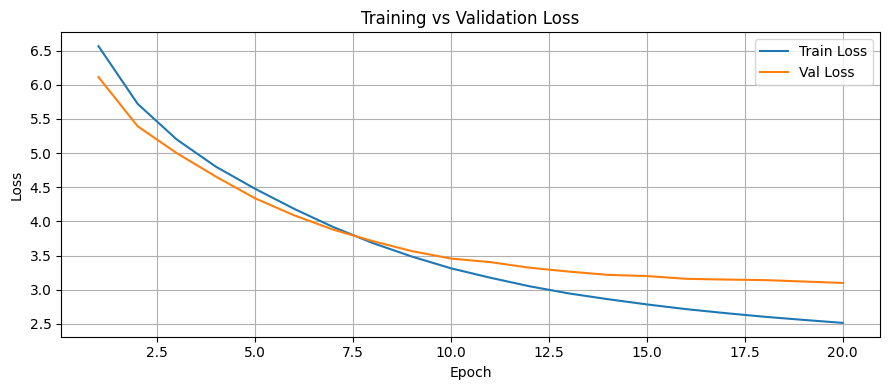

In [10]:
plt.figure(figsize=(9, 4))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=150)
plt.show()

In [11]:
def greedy_translate(sentence):
    model.eval()
    src = torch.tensor(eng_vocab.encode(clean(sentence)),
                       dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        enc_out, src_mask = model.encode(src)

    start_id = spa_vocab.w2i.get('[start]', 1)
    end_id   = spa_vocab.w2i.get('[end]',   1)

    dec_input = torch.tensor([[start_id]], dtype=torch.long).to(device)
    result    = []

    with torch.no_grad():
        for _ in range(MAX_LEN - 1):
            logits  = model.decode(dec_input, enc_out, src_mask)
            next_id = logits[:, -1, :].argmax(dim=-1).item()
            if next_id == end_id:
                break
            result.append(next_id)
            dec_input = torch.cat([dec_input,
                                   torch.tensor([[next_id]], device=device)], dim=1)

    return spa_vocab.decode(result) if result else '<no output>'

In [12]:
test_en = [eng_sentences[i] for i in te_idx]
test_es = [spa_sentences[i] for i in te_idx]

samples = random.sample(range(len(test_en)), 5)

for k, i in enumerate(samples, 1):
    src  = test_en[i]
    ref  = test_es[i].replace('[start] ', '').replace(' [end]', '')
    pred = greedy_translate(src)
    print(f'Example {k}')
    print(f'  English   : {src}')
    print(f'  Target    : {ref}')
    print(f'  Predicted : {pred}')
    print()

Example 1
  English   : i m likely going to be fired for doing that
  Target    : es más que probable que me despidan por hacerlo
  Predicted : me parece que me va a estar despedido

Example 2
  English   : tell me where to go
  Target    : indícame adónde ir
  Predicted : dime dónde ir

Example 3
  English   : i resign
  Target    : dimito
  Predicted : yo lo dejo

Example 4
  English   : call security
  Target    : llama a seguridad
  Predicted : llamad a seguridad

Example 5
  English   : you re the owner
  Target    : tú eres el propietario
  Predicted : eres el dueño



## Analysis: Self-Attention vs Cross-Attention in Translation

In a translation model, we need two different types of attention and each does a different job.

Self-attention is used within a single sequence. In the encoder, every English word attends to every other English word in the same sentence. This matters because word meaning often depends on context — the word "bank" means something different in "river bank" versus "bank account". Without self-attention, each word would just be a fixed embedding with no awareness of the words around it. In the decoder, self-attention works over the Spanish tokens already generated, which helps the model stay consistent — for example, making sure a pronoun matches the gender of a noun mentioned earlier.

Cross-attention is what connects the encoder and decoder. The decoder uses its current hidden state as the Query, and uses the encoder output as both the Key and Value. This means that when the model is deciding what Spanish word to produce next, it can look back at any part of the English sentence. In practice this acts like an alignment mechanism — when generating "gato" the decoder attends strongly to "cat", when generating "corre" it attends to "runs" and so on.

Both are needed. Self-attention alone gives you context within one language but no way to bridge between the two. Cross-attention alone would give you access to the source but no internal coherence in the output. Together they let the model understand the input deeply and generate a grammatically correct, semantically faithful translation.